# K線 反轉型態 - 多頭吞噬/空頭吞噬型態 

# Part 0: Import 套件

- TA-Lib: https://mrjbq7.github.io/ta-lib/install.html
- plotly: https://plotly.com/python/
- yfinance: https://pypi.org/project/yfinance/

In [2]:
#財經分析套件
import talib

# 下載資料套件
import yfinance as yf
import requests as r

#資料處理套件
import pandas as pd
import json
from datetime import datetime, date

# 畫圖套件
import plotly.graph_objects as go

如果沒有上述套件 可以用pip install 或 conda install 指令安裝
1. pip install
    - pip install plotly
    - pip install TA-Lib
    - pip install yfinance
2. conda install
    - conda install -c plotly plotly
    - conda install -c conda-forge ta-lib

# Part 1: 在台股個股Ｋ線圖上，標示出 多頭吞噬/空頭吞噬 Ｋ線型態

## 1.1 下載台股個股歷史走勢資料

- 股海小英雄youtube影片：[【Python 爬蟲】台股個股資料免費下載｜選擇想要的個股資料！](https://youtu.be/_4CEymrQbV8)
- 資料來源：[證交所 個股日成交資訊](https://www.twse.com.tw/zh/page/trading/exchange/STOCK_DAY.html)

In [3]:
def get_tw_stock_data(start_year, start_month, end_year, end_month, stock_code):
    start_date = str(date(start_year, start_month, 1))
    end_date = str(date(end_year, end_month, 1))
    month_list = pd.date_range(start_date, end_date, freq='MS').strftime("%Y%m%d").tolist()
    
    df = pd.DataFrame()
    for month in month_list:
        url = "https://www.twse.com.tw/exchangeReport/STOCK_DAY?response=json&date="+ month + "&stockNo=" + str(stock_code)
        res = r.get(url)
        stock_json = res.json()
        stock_df = pd.DataFrame.from_dict(stock_json['data'])
        df = df.append(stock_df, ignore_index = True)
        
    # 資料轉型
    for col in [0, 1, 2, 3, 4, 5, 6, 8]:
        for row in range(df.shape[0]):
            # 把"日期"從字串(string)換成時間(datetime)，並將民國年換成西元年
            if col == 0:
                day = df.iloc[row,0].split('/')
                df.iloc[row, 0] = datetime(int(day[0]) + 1911, int(day[1]), int(day[2]))  
            # 把"開盤價", "最高價", "最低價", "收盤價"帶有逗號的字串(string)換成浮點數(float) 
            elif col != 0:
                df.iloc[row, col] = float(df.iloc[row,col].replace(',', ''))
    
    df.columns = ['日期', '成交股數', '成交金額', '開盤價', '最高價', '最低價', '收盤價', '漲跌價差', '成交筆數']
    return df

In [4]:
#下載台股長榮海運:2603
df = get_tw_stock_data(start_year = 2021, 
                       start_month = 6, 
                       end_year = 2021, 
                       end_month = 8, 
                       stock_code = 2603)
df.head()

,日期,成交股數,成交金額,開盤價,最高價,最低價,收盤價,漲跌價差,成交筆數
0,2021-06-01 00:00:00,542547770.0,55984576106.0,101.5,108.0,98.2,108.0,+9.40,196823.0
1,2021-06-02 00:00:00,696150855.0,78107414405.0,110.0,115.5,108.5,110.5,+2.50,232375.0
2,2021-06-03 00:00:00,561492548.0,65330004183.0,114.0,121.0,112.5,119.0,+8.50,185050.0
3,2021-06-04 00:00:00,440988606.0,52466457011.0,119.0,121.5,116.0,116.5,-2.50,174236.0
4,2021-06-07 00:00:00,669467351.0,74752165886.0,119.0,120.5,105.0,110.5,-6.00,248926.0


## 1.2: 用Ta-Lib套件，找出 多頭吞噬/空頭吞噬 K線型態
- [Ta-Lib K線型態介紹](https://www.quantshare.com/index.php?option=manual&dir=/QuantShare%20Language/Candlestick%20Pattern)

### Ta-Lib支援的K線型態們

In [5]:
print(talib.get_function_groups()['Pattern Recognition'])

['CDL2CROWS', 'CDL3BLACKCROWS', 'CDL3INSIDE', 'CDL3LINESTRIKE', 'CDL3OUTSIDE', 'CDL3STARSINSOUTH', 'CDL3WHITESOLDIERS', 'CDLABANDONEDBABY', 'CDLADVANCEBLOCK', 'CDLBELTHOLD', 'CDLBREAKAWAY', 'CDLCLOSINGMARUBOZU', 'CDLCONCEALBABYSWALL', 'CDLCOUNTERATTACK', 'CDLDARKCLOUDCOVER', 'CDLDOJI', 'CDLDOJISTAR', 'CDLDRAGONFLYDOJI', 'CDLENGULFING', 'CDLEVENINGDOJISTAR', 'CDLEVENINGSTAR', 'CDLGAPSIDESIDEWHITE', 'CDLGRAVESTONEDOJI', 'CDLHAMMER', 'CDLHANGINGMAN', 'CDLHARAMI', 'CDLHARAMICROSS', 'CDLHIGHWAVE', 'CDLHIKKAKE', 'CDLHIKKAKEMOD', 'CDLHOMINGPIGEON', 'CDLIDENTICAL3CROWS', 'CDLINNECK', 'CDLINVERTEDHAMMER', 'CDLKICKING', 'CDLKICKINGBYLENGTH', 'CDLLADDERBOTTOM', 'CDLLONGLEGGEDDOJI', 'CDLLONGLINE', 'CDLMARUBOZU', 'CDLMATCHINGLOW', 'CDLMATHOLD', 'CDLMORNINGDOJISTAR', 'CDLMORNINGSTAR', 'CDLONNECK', 'CDLPIERCING', 'CDLRICKSHAWMAN', 'CDLRISEFALL3METHODS', 'CDLSEPARATINGLINES', 'CDLSHOOTINGSTAR', 'CDLSHORTLINE', 'CDLSPINNINGTOP', 'CDLSTALLEDPATTERN', 'CDLSTICKSANDWICH', 'CDLTAKURI', 'CDLTASUKIGAP', 'CDL

### Ta-Lib K線型態函式名稱
- 吞噬: 'CDLENGULFING'

### Ta-Lib K線型態函式回傳值
- 偏上漲型態: +100
- 無此型態: 0
- 偏下跌型態: -100

### 計算 吞噬 型態

In [6]:
# 使用ta-lib吞噬型態函式
candle_names = ['CDLENGULFING']

# 加K線型態的欄位 create columns for  pattern
for candle in candle_names:
    df[candle] = getattr(talib, candle)(df['開盤價'], df['最高價'], df['最低價'], df['收盤價'])

df.head()

,日期,成交股數,成交金額,開盤價,最高價,最低價,收盤價,漲跌價差,成交筆數,CDLENGULFING
0,2021-06-01 00:00:00,542547770.0,55984576106.0,101.5,108.0,98.2,108.0,+9.40,196823.0,0
1,2021-06-02 00:00:00,696150855.0,78107414405.0,110.0,115.5,108.5,110.5,+2.50,232375.0,0
2,2021-06-03 00:00:00,561492548.0,65330004183.0,114.0,121.0,112.5,119.0,+8.50,185050.0,0
3,2021-06-04 00:00:00,440988606.0,52466457011.0,119.0,121.5,116.0,116.5,-2.50,174236.0,0
4,2021-06-07 00:00:00,669467351.0,74752165886.0,119.0,120.5,105.0,110.5,-6.00,248926.0,0


### 找出 吞噬: 'CDLENGULFING' 型態
- 'CDLENGULFING' 函式回傳值 **100**: 多頭吞噬，偏上漲型態
- 'CDLENGULFING' 函式回傳值 **-100**: 空頭吞噬，偏下跌型態

In [7]:
idx = df[df['CDLENGULFING']!= 0].index
df[df['CDLENGULFING']!= 0]

,日期,成交股數,成交金額,開盤價,最高價,最低價,收盤價,漲跌價差,成交筆數,CDLENGULFING
16,2021-06-24 00:00:00,135489137.0,19902117472.0,136.5,152.0,136.0,152.0,+13.50,74539.0,100
28,2021-07-12 00:00:00,62036379.0,11478840019.0,195.0,197.5,174.5,183.0,-4.00,37539.0,-100
42,2021-07-30 00:00:00,775707663.0,110746265916.0,145.0,150.5,131.0,132.0,-12.50,342643.0,-100


## 1.3: 在台股個股Ｋ線圖上，標示出吞噬Ｋ線型態
- 股海小英雄youtube影片：[【股市分析】用K線預測大盤趨勢](https://youtu.be/FX6YAyOdEaE)

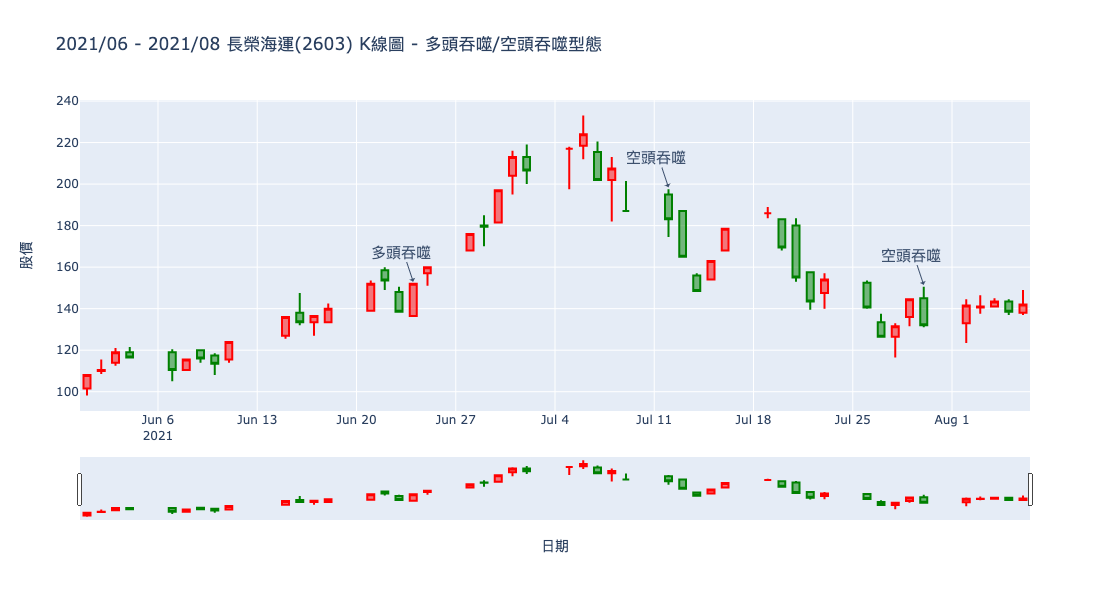

In [13]:
# 畫大盤Ｋ線圖
fig = go.Figure(data = [go.Candlestick(x = df['日期'],
                open = df['開盤價'],
                high = df['最高價'],
                low = df['最低價'],
                close = df['收盤價'],
                increasing_line_color = 'red', 
                decreasing_line_color = 'green')])
# 標示吞噬型態
for i in range(len(idx)):
    day = df.iloc[idx[i], 0]
    direction = '多頭' if df.iloc[idx[i], -1] > 0 else '空頭'
    high = float(df[df['日期'] == day]['最高價'])
    fig.add_annotation(x = day, 
                       y = high + 1,
                       opacity = 0.9,
                       font_size = 15,
                       text = direction + "吞噬 ",
                       showarrow = True,
                       arrowhead = 1)
    
# 設圖標及圖長寬
fig.update_layout(
    title_text = "2021/06 - 2021/08 長榮海運(2603) K線圖 - 多頭吞噬/空頭吞噬型態",
    width = 1000,
    height = 600
)
# 設x軸標題
fig.update_xaxes(title_text = "日期")

# 設y軸標題
fig.update_yaxes(title_text = "股價")

fig.show()

# Part 2: 在陸股個股Ｋ線圖上，標示出 多頭吞噬/空頭吞噬 Ｋ線型態

## 2.1 下載陸股個股歷史走勢資料
- 股海小英雄youtube影片：[【Python 股票】美股個股資料免費下載｜用Yahoo財經套件(yfinance)取得資料｜擺脫限制](https://youtu.be/ZIFmDbIb-ro)

In [14]:
# 下載A股貴州茅台：600519.SS
stock = yf.download("600519.SS", "2021-02-05", "2021-06-06")
stock.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-02-05,2325.000000,2364.600098,2291.0,2313.000000,2291.421875,3972906
2021-02-08,2337.000000,2378.879883,2313.0,2368.800049,2346.701416,3578573
2021-02-09,2368.800049,2456.429932,2350.0,2456.429932,2433.513672,3329655
2021-02-10,2485.000000,2601.199951,2485.0,2601.000000,2576.735107,6137057
2021-02-18,2587.979980,2627.879883,2465.0,2471.000000,2447.947754,6591232


## 2.2: 用Ta-Lib套件，找出 多頭吞噬/空頭吞噬 K線型態
### 計算 吞噬 型態

In [15]:
# 使用ta-lib吞噬型態函式
df = stock
candle_names = ['CDLENGULFING']

# 加各種K線型態的欄位 create columns for  pattern
for candle in candle_names:
    df[candle] = getattr(talib, candle)(df['Open'], df['High'], df['Low'], df['Close'])

df.head()

,Open,High,Low,Close,Adj Close,Volume,CDLENGULFING
Date,,,,,,,
2021-02-05,2325.000000,2364.600098,2291.0,2313.000000,2291.421875,3972906,0
2021-02-08,2337.000000,2378.879883,2313.0,2368.800049,2346.701416,3578573,0
2021-02-09,2368.800049,2456.429932,2350.0,2456.429932,2433.513672,3329655,0
2021-02-10,2485.000000,2601.199951,2485.0,2601.000000,2576.735107,6137057,0
2021-02-18,2587.979980,2627.879883,2465.0,2471.000000,2447.947754,6591232,0


### 找出 吞噬: 'CDLENGULFING' 型態
- 'CDLENGULFING' 函式回傳值 **100**: 多頭吞噬，偏上漲型態
- 'CDLENGULFING' 函式回傳值 **-100**: 空頭吞噬，偏下跌型態

In [16]:
idx = df[df['CDLENGULFING']!= 0].index
df[df['CDLENGULFING']!= 0]

,Open,High,Low,Close,Adj Close,Volume,CDLENGULFING
Date,,,,,,,
2021-02-24,2307.989990,2310.0,2160.500000,2189.0,2168.578613,8211578,-100
2021-03-08,2074.959961,2085.0,1960.000000,1960.0,1941.714966,6309959,-100
2021-04-22,2089.899902,2099.0,2051.500000,2055.5,2036.324097,2685002,-100
2021-05-11,1876.000000,1966.0,1873.300049,1959.0,1940.724365,4249412,100


## 2.3: 在陸股個股Ｋ線圖上，標示出吞噬Ｋ線型態
- 股海小英雄youtube影片：[【股市分析】用K線預測大盤趨勢](https://youtu.be/FX6YAyOdEaE)

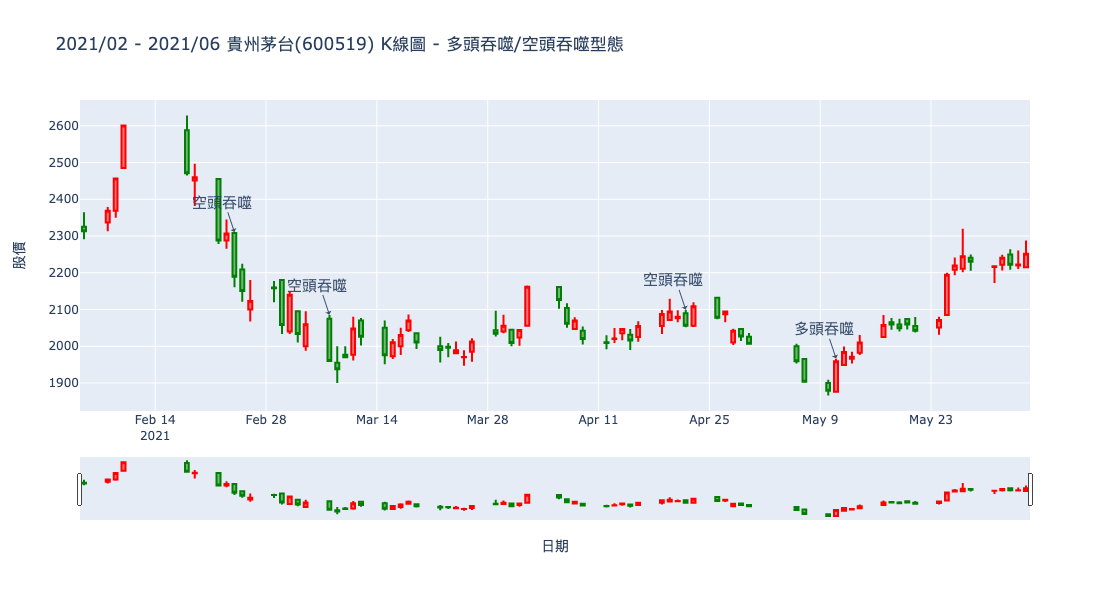

In [19]:
# 畫大盤Ｋ線圖
fig = go.Figure(data = [go.Candlestick(x = df.index,
                open = df['Open'],
                high = df['High'],
                low = df['Low'],
                close = df['Close'],
                increasing_line_color = 'red', 
                decreasing_line_color = 'green')])
# 標示吞噬型態
for i in range(len(idx)):
    day = idx[i]
    direction = '多頭' if df.loc[day][-1] > 0 else '空頭'
    high = df.loc[day][1]
    fig.add_annotation(x = day, 
                       y = high + 1,
                       opacity = 0.9,
                       font_size = 15,
                       text = direction + "吞噬 ",
                       showarrow = True,
                       arrowhead = 1)
    
# 設圖標及圖長寬
fig.update_layout(
    title_text = "2021/02 - 2021/06 貴州茅台(600519) K線圖 - 多頭吞噬/空頭吞噬型態",
    width = 1000,
    height = 600
)
# 設x軸標題
fig.update_xaxes(title_text = "日期")

# 設y軸標題
fig.update_yaxes(title_text = "股價")

fig.show()